In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 21.1 s


In [3]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [4]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [5]:
stage = stage_list[0] 
stage.shape # stage 1 obs


(202, 4, 193)

In [6]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

meansd.shape,time_length.shape

((5, 5, 2), (4, 2))

In [7]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

period_num,var_num,durations_num,replay_num

(5, 5, 4, 202)

In [8]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')

emu

array([ 21.84028435,  40.84634018,   5.01133823], dtype=float32)

In [9]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length, dtype='float32')
_time_axis = np.tile(time_axis,(202, 2, 1)) # add batch...
_time_axis.shape

(202, 2, 193)

这里我们建模策略不同仅仅体现在阶段消耗时间上的差别。尽管策略似乎也可以看做与那五个参数有关。

In [10]:
# Model

# 开始设定S个策略，这里先硬编码为3个，且手动设定其先验分布使其倾向于体现短中长的分类

S = 3

#_idurations_loc_param = np.array([[70.0,40.0],[80.0,50.0],[90.0,60.0]],dtype='float32')
_idurations_loc_param = np.array([[80.0,50.0],[80.0,50.0],[80.0,50.0]],dtype='float32') # 平衡赋值先验，看看会怎么分叉

durations_loc_param = Normal(loc = _idurations_loc_param, scale = [[7.0,4.0],[8.0,5.0],[9.0,6.0]]) # 3 x 2 matrix 3 for 策略数, 2 for 阶段数-1

# 所有回放从一个logit化的离散分布中抽值作为其选择哪个的标准

loc_weights = Normal(loc=[0.,0.,0.],scale=[1.,1.,1.])

loc_index = ed.models.Categorical(logits = loc_weights,sample_shape = replay_num)

durations_loc = tf.gather(durations_loc_param, loc_index) 

durations_scale =  durations_loc / 10.0 # 暂时没想到什么办法确定这个参数

durations = ed.models.Normal(loc = durations_loc, scale=durations_scale) # 202 * 2 matrix # yep we remove the sample_shape to fit new extent


In [11]:
durations_loc_param.eval()

array([[ 70.72158051,  43.55698013],
       [ 76.54021454,  51.11285019],
       [ 83.89641571,  47.16188049]], dtype=float32)

In [12]:
loc_index.eval()

array([1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1,
       2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1])

In [13]:
durations.eval()

array([[ 55.29297256,  49.29670715],
       [ 68.5609436 ,  46.70132446],
       [ 96.24385071,  44.5506134 ],
       [ 73.18545532,  40.99508667],
       [ 72.04800415,  53.02204514],
       [ 82.66457367,  46.68419266],
       [ 80.35453796,  38.74972916],
       [ 72.26846313,  51.33052444],
       [ 70.87432098,  42.88764572],
       [ 75.05715179,  52.8666954 ],
       [ 80.0559845 ,  40.05907059],
       [ 83.52784729,  43.79304123],
       [ 69.63967133,  50.97179031],
       [ 86.55909729,  51.52335739],
       [ 76.09723663,  44.12115097],
       [ 74.2410202 ,  54.06944656],
       [ 81.63981628,  52.21596909],
       [ 73.80549622,  50.07658768],
       [ 67.57273102,  44.45510864],
       [ 76.22471619,  39.4134903 ],
       [ 79.86830902,  54.33990479],
       [ 65.35097504,  52.93648529],
       [ 68.05739594,  52.87115097],
       [ 82.15088654,  48.53920364],
       [ 81.89865112,  44.7452507 ],
       [ 79.60203552,  50.1692543 ],
       [ 72.11720276,  46.76083374],
 

In [14]:
# The part of Origin MODEL

breaks = tf.cumsum(durations, axis=1) # 202 * 2 matrix
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, tf.ones((replay_num,2,stage_length),dtype=tf.int32), tf.zeros((replay_num,2,stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

# 几个参数就不一样了

_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')

shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
x_mu = ed.models.Exponential(rate = 1/_x_mu)
move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。

def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
x_mu_time = share_params_into_period(x_mu, index)
move_mu_time = share_params_into_period(move_mu, index)
move_sd_time = share_params_into_period(move_sd, index)

pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
pressing_x = ed.models.Poisson(rate = x_mu_time)
move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)

move

<ed.RandomVariable 'Normal_11/' shape=(202, 193) dtype=float32>

In [15]:
shift_mu_time.eval()

array([[ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154],
       [ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154],
       [ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154],
       ..., 
       [ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154],
       [ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154],
       [ 7.44930696,  7.44930696,  7.44930696, ...,  6.56925154,
         6.56925154,  6.56925154]], dtype=float32)

In [16]:
shift_mu_time

<tf.Tensor 'stack:0' shape=(202, 193) dtype=float32>

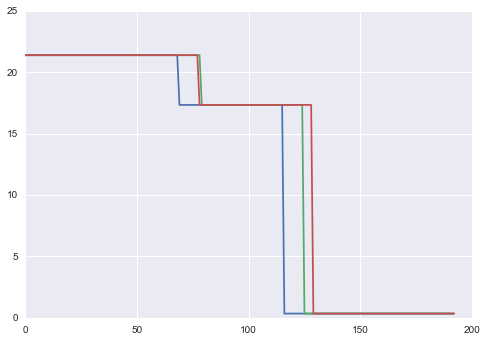

In [17]:
plt.plot(shift_mu_time.eval()[:3,:].T)

如上图所示，开头与结尾的按列看模拟值都一样是因为阶段划分本来就不可能在那个位置，于是开头与结尾几个格一定处于同一阶段，
而目前该模型的pressing_shift参数与策略是无关的。策略决定的是阶段的时长的期望，虽然有一些随机性，但目前我在上面看到的图那几十的差距不是
固定时长期望分布的标准差可以描述的。

In [20]:
# Inference
T = 30000

# 原来先对随机参数durations的后验推断改为推断控制durations隐变量的随机参数的后验分布

idurations_loc_param = np.ones([T, 3, 2],dtype='float32')
idurations_loc_param[0,:,:] = _idurations_loc_param
qdurations_loc_param = ed.models.Empirical(tf.Variable(idurations_loc_param))

# 分配向量概率，既然它本身是正态分布，我们也可以把它看成经过自带的softmax变换

iloc_weights = np.zeros([T,3],dtype='float32') # 就以0,0,0权重开始搜索
qloc_weights = ed.models.Empirical(tf.Variable(iloc_weights))


In [21]:
# duration现在是策略选择和策略权重的随机函数，不需要直接设定近似
'''
idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))
'''

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,3],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,3],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,3],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,3],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,3],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


In [22]:
# proposal variable

#gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

gdurations_loc_param = Normal(loc = durations_loc_param, scale = [[0.1,0.1],[0.1,0.1],[0.1,0.1]])
gloc_weights = Normal(loc = loc_weights, scale = [0.1,0.1,0.1])

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差.[rollback]
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale, poi_scale, poi_scale])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale, poi_scale, poi_scale])
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale, poi_scale, poi_scale])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01,0.01,0.01])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale, sd_scale, sd_scale])


In [23]:
inference = ed.MetropolisHastings({durations_loc_param: qdurations_loc_param, loc_weights: qloc_weights,
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations_loc_param: gdurations_loc_param, loc_weights: gloc_weights,
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [24]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 923s | Acceptance Rate: 0.371


In [25]:
# 虽然这个代码块运行的时候里面还有些变量没定义。。
# 用了这个和新实现的轮换MH算法才发现那些泊松分布的变量很难优化，而duration和move的参数则无压力。可以把那些泊松分布的proposal分布标准差再
# 改小点
def diagnose(channel = None, focus = 0):
    channel = focus if channel == None else channel
    plt.plot(qshift_mu.params.eval()[:,channel])
    plt.title('qshift_mu 0')
    plt.show()
    plt.plot(qctrl_mu.params.eval()[:,channel])
    plt.title('qctrl_mu 0')
    plt.show()
    plt.plot(qx_mu.params.eval()[:,channel])
    plt.title('qx_mu 0')
    plt.show()
    plt.plot(qmove_mu.params.eval()[:,channel])
    plt.title('qmove_mu 0')
    plt.show()
    plt.plot(qmove_sd.params.eval()[:,channel])
    plt.title('qmove_sd 0')
    plt.show()
    '''
    plt.plot(qdurations.params[:,0,:].eval())
    plt.show('gdurations replay 0')
    plt.show()
    '''
    

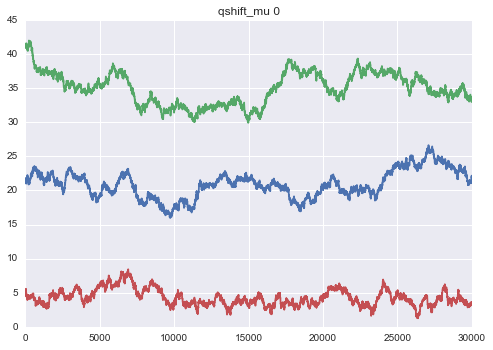

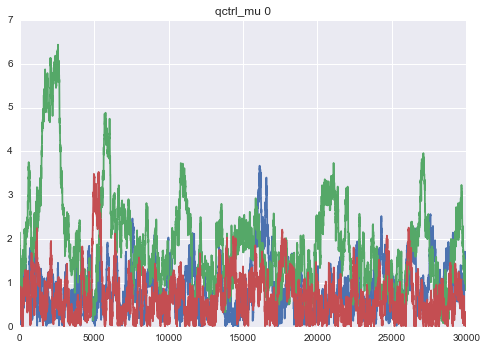

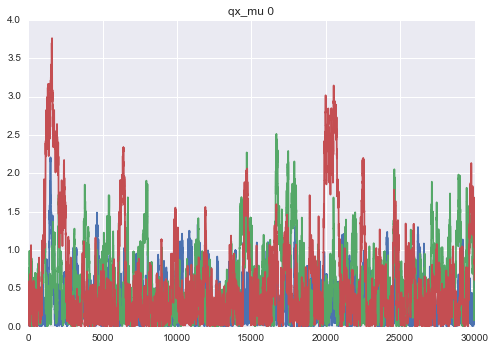

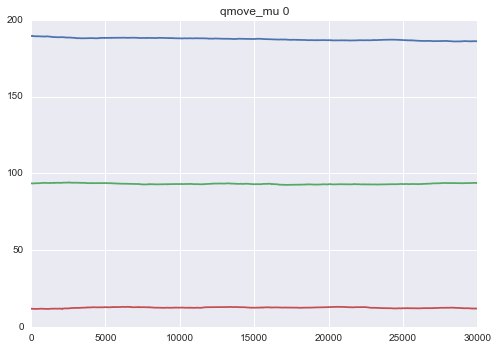

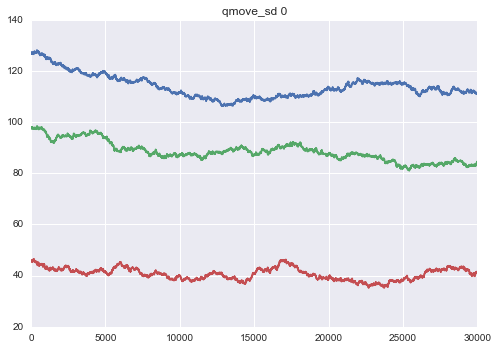

In [26]:
diagnose([0,1,2])

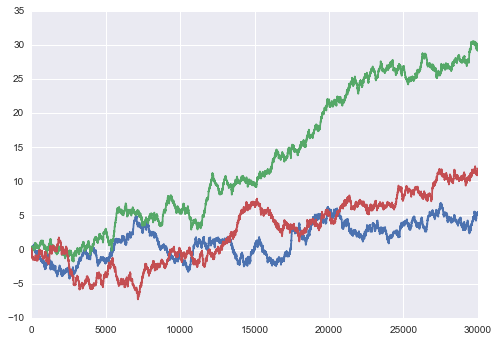

In [27]:
# 上面的diagnose删去了以前模型中与durations的部分，因为其决定结构变了，这里重新审查

plt.plot(qloc_weights.params.eval())

In [37]:
ed.models.Categorical(logits=qloc_weights.params.eval()[-1,:]).sample(100).eval()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

这么看应该是softmax了。。

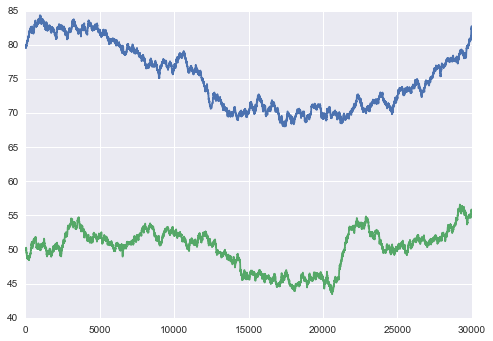

In [28]:
plt.plot(qdurations_loc_param.params.eval()[:,0,:])

In [29]:
def logit(x):
    return np.log(x/(1-x))
def logistic(x):
    return 1/(1+np.exp(-x))
def logistic_to_1(x):
    lx = logistic(x)
    return np.transpose(np.transpose(lx) / np.sum(lx,axis=1))
def softmax(x):
    ex = np.exp(x)
    return np.transpose(np.transpose(ex) / np.sum(ex,axis=1))

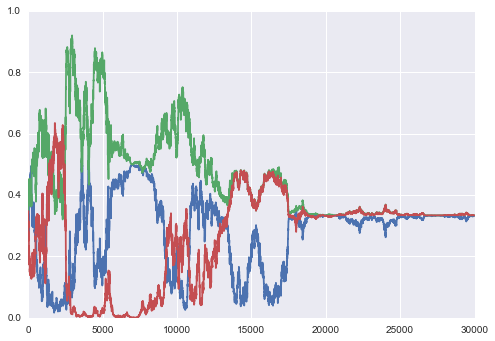

In [30]:
plt.plot(logistic_to_1(qloc_weights.params.eval()))

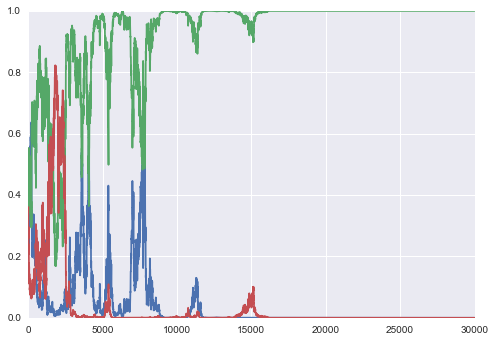

In [31]:
plt.plot(softmax(qloc_weights.params.eval()))

所以它这个自带的logit是softmax变换还是那个逻辑斯克变换再归一化？。。另外这结果也太恶心了。

In [48]:
qloc_weights.params.eval()

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       ..., 
       [-17.64663506,  -3.5759027 , -20.22221184],
       [-17.64663506,  -3.5759027 , -20.22221184],
       [-17.53725052,  -3.49186325, -20.15807915]], dtype=float32)

其实也很合理，因为中间那个的先验几乎是标准答案。。就压过其他两个风头，虽然本来这两个本来有助于解释散度的，但好像被MH看出来了。
但如果是这样的话，把答案改成不那么标准会怎么样？或者都改成标准答案看看它会怎么分歧？

先试试全是标准答案版本：

In [61]:
# Inference
T = 30000

# 原来先对随机参数durations的后验推断改为推断控制durations隐变量的随机参数的后验分布


idurations_loc_param = np.ones([T, 3, 2],dtype='float32')
idurations_loc_param[0,:,:] = _idurations_loc_param
qdurations_loc_param = ed.models.Empirical(tf.Variable(idurations_loc_param))

# 分配向量概率，既然它本身是正态分布，我们也可以把它看成经过自带的softmax变换

iloc_weights = np.zeros([T,3],dtype='float32') # 就以0,0,0权重开始搜索
qloc_weights = ed.models.Empirical(tf.Variable(iloc_weights))

# duration现在是策略选择和策略权重的随机函数，不需要直接设定近似
'''
idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))
'''

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,3],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,3],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,3],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,3],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,3],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


In [62]:
# proposal variable

#gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

gdurations_loc_param = Normal(loc = durations_loc_param, scale = [[0.1,0.1],[0.1,0.1],[0.1,0.1]])
gloc_weights = Normal(loc = loc_weights, scale = [0.1,0.1,0.1])

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差.[rollback]
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale, poi_scale, poi_scale])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale, poi_scale, poi_scale])
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale, poi_scale, poi_scale])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01,0.01,0.01])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale, sd_scale, sd_scale])


In [63]:
inference.run()

 6600/30000 [ 22%] ██████                         ETA: 360s | Acceptance Rate: 0.122

KeyboardInterrupt: 

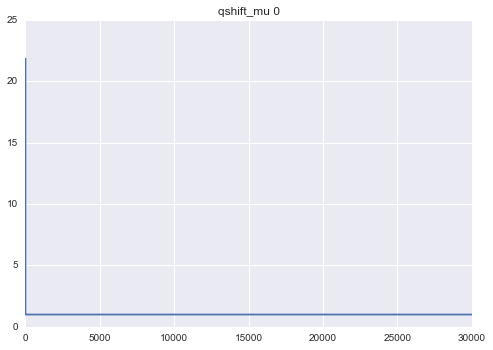

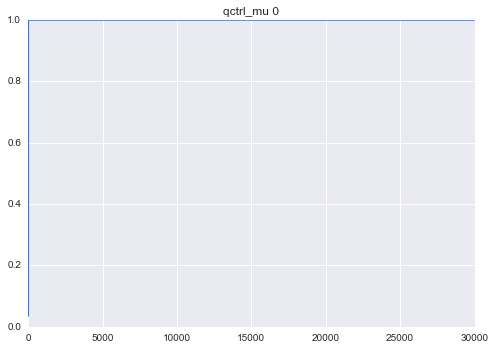

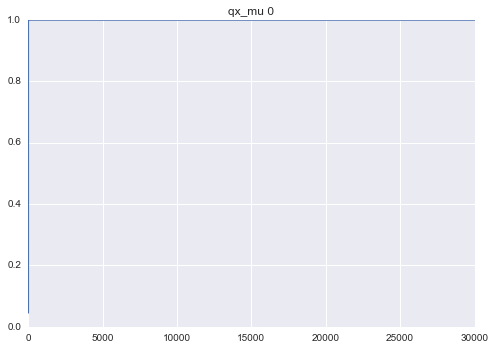

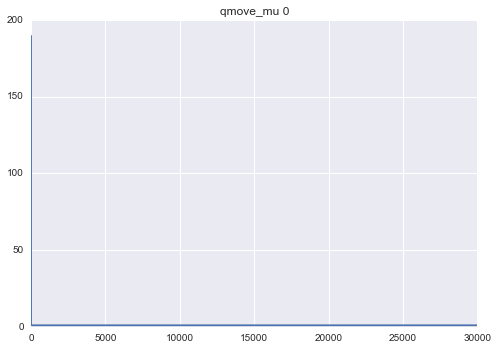

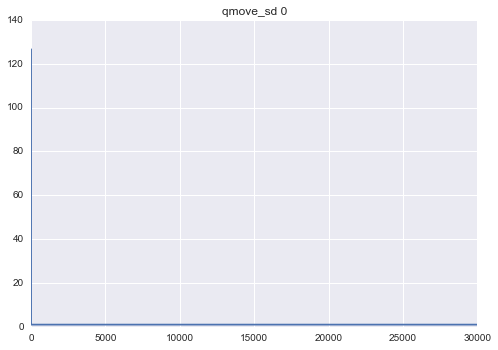

In [64]:
diagnose()

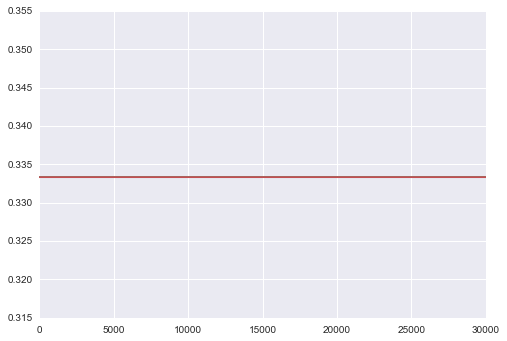

In [65]:
plt.plot(logistic_to_1(qloc_weights.params.eval()))

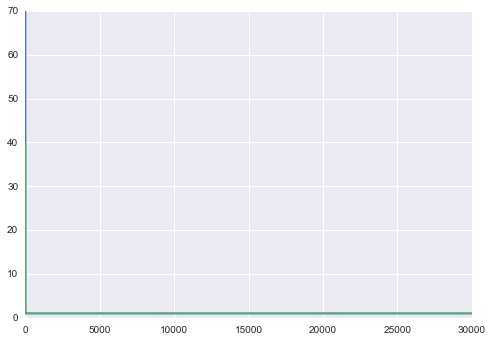

In [66]:
plt.plot(qdurations_loc_param.params.eval()[:,0,:])